In [166]:
%matplotlib inline

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [167]:
# Configure libraries
sns.set()

# Round decimals when displaying DataFrames
pd.set_option('precision', 4)

In [168]:
# load dataset
billboardWeekly = pd.read_csv('billboardHotWeekly.csv')

In [169]:
# create a new dictionary and store the max number of weeks on chart for each song/instance
dictSortIndex = {}
# number of songs that have been #1 on the list
peakList = []
for row in billboardWeekly.itertuples():
    # save to peak1 list
    if row.PeakPosition == 1:
        if not (row.SongID in peakList):
            peakList.append(row.SongID)
    # max weeks_on_chart
    if row.SongID in dictSortIndex.keys():
        if row.Instance in ((dictSortIndex[row.SongID]).keys()):
            if (dictSortIndex[row.SongID])[row.Instance] < row.WeeksOnChart:
                (dictSortIndex[row.SongID])[row.Instance] = row.WeeksOnChart
        else:
            (dictSortIndex[row.SongID])[row.Instance] = row.WeeksOnChart
    else:
        dictSortIndex[row.SongID] = {}
        (dictSortIndex[row.SongID])[row.Instance] = row.WeeksOnChart

In [170]:
# list of songs that have been popular for more than a year        
popularSongs = []
for pair1 in dictSortIndex:
    tempSum = 0
    for pair2 in dictSortIndex[pair1]:
        tempSum = tempSum + dictSortIndex[pair1][pair2]
    if tempSum >= 51:
        popularSongs.append(pair1)
# percentage of songs that have been popular for more than a year vs. total songs
popularMoreThan1Yr = ((len(popularSongs))/(len(dictSortIndex.keys())))

# songs that have been #1 & were popular for more than a year
superPopular = []
for song in peakList:
    if song in popularSongs:
        superPopular.append(song)

In [171]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

#Get authorization key to use Spotify API from developer account
client_credentials_manager = SpotifyClientCredentials('84b5738225894c76aecf0578c6ff2862', '89d0aeb4ee7c4841b5800cd068ee3f69')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [172]:
#cleaning the data for input into the spotify API
df = billboardWeekly[billboardWeekly['SongID'].isin(peakList)]
df = df.drop_duplicates(subset='SongID')
#copy over song, artist, and week at number one into a new dataframe
sp_df = df[['Song', 'Performer', 'WeekID'].copy()]
sp_df = sp_df.reset_index(drop='True')
sp_df['Song'] = sp_df['Song'].str.replace("'",'')
sp_df['Song'] = sp_df['Song'].str.replace('"','')
sp_df['Song'] = sp_df['Song'].str.replace(',','')
sp_df['Song'] = sp_df['Song'].str.replace('&','')
sp_df['Song'] = sp_df['Song'].str.split('/').str[0]
sp_df['Song'] = sp_df['Song'].str.split('-').str[0]
sp_df['Song'] =sp_df['Song'].str.replace(r"\(.*\)","")
sp_df['Performer'] = sp_df['Performer'].str.replace('&','')
sp_df['Performer'] = sp_df['Performer'].str.replace("Featuring",'')
sp_df['Performer'] = sp_df['Performer'].str.replace("With",'')
sp_df['Performer'] = sp_df['Performer'].str.replace("And",'')
sp_df['Performer'] = sp_df['Performer'].str.replace(r"\(.*\)","")
print(sp_df)

                              Song                          Performer  \
0              Dont Wanna Lose You                     Gloria Estefan   
1             Dont Worry Be Happy                      Bobby McFerrin   
2                        Dont You                        Simple Minds   
3                 Poor Little Fool                       Ricky Nelson   
4                    One Sweet Day          Mariah Carey  Boyz II Men   
...                            ...                                ...   
1084                 Youre So Vain                        Carly Simon   
1085     Youre The One That I Want  John Travolta  Olivia Newton-John   
1086            Youve Got A Friend                       James Taylor   
1087  Youve Lost That Lovin Feelin             The Righteous Brothers   
1088           Tonights The Night                         Rod Stewart   

          WeekID  
0       7/8/1989  
1      7/30/1988  
2      2/23/1985  
3       8/2/1958  
4      12/2/1995  
...      

In [173]:
#loading the attributes retrieved from Spotify API into series
dance = []
energy = []
speech = []
acoustic = []
valence = []
tempo = []
for i in sp_df.index:
    #get the name of artist and song
    artist = sp_df.loc[i,'Performer']
    track = sp_df.loc[i, 'Song']
    #use search function in spotify API
    track_search = sp.search(q='artist:' + artist + ' track:' + track, limit=1, type='track')
    #return 'none' if the track does not come up in search
    if track_search['tracks']['total'] == 0:
        track_id = 'none'
    #get track ID to retrieve audio features
    else:
        track_id = track_search['tracks']['items'][0]['id']
    atts = sp.audio_features(track_id)
    #if the song has no attributes, append null values
    if atts == [None]:
        dance.append('NaN')
        energy.append('NaN')
        speech.append('Nan')
        acoustic.append('NaN')
        valence.append('NaN')
        tempo.append('NaN')
    #append features to the respective series
    else:
        dance.append(atts[0]['danceability'])
        energy.append(atts[0]['energy'])
        speech.append(atts[0]['speechiness'])
        acoustic.append(atts[0]['acousticness'])
        valence.append(atts[0]['valence'])
        tempo.append(atts[0]['tempo'])

In [174]:
#add series as columns into the new dataframe
sp_df['danceability'] = dance
sp_df['energy'] = energy
sp_df['speechiness'] = speech
sp_df['acousticness'] = acoustic
sp_df['valence'] = valence
sp_df['tempo'] = tempo
#get rid of all null values
sp_df = sp_df[sp_df['danceability'] != 'NaN' ]
#get only the first three digits of the year the song was at number 1
sp_df['WeekID'] = sp_df['WeekID'].str[-4:-1]

In [175]:
#load data into seperate data frames based on decade
fifties = sp_df.loc[sp_df['WeekID'] == '195']
sixties = sp_df.loc[sp_df['WeekID'] == '196']
seventies = sp_df.loc[sp_df['WeekID'] == '197']
eighties = sp_df.loc[sp_df['WeekID'] == '198']
nineties = sp_df.loc[sp_df['WeekID'] == '199']
oughts = sp_df.loc[sp_df['WeekID'] == '200']
tens = sp_df.loc[sp_df['WeekID'] == '201']
#done data cleaning

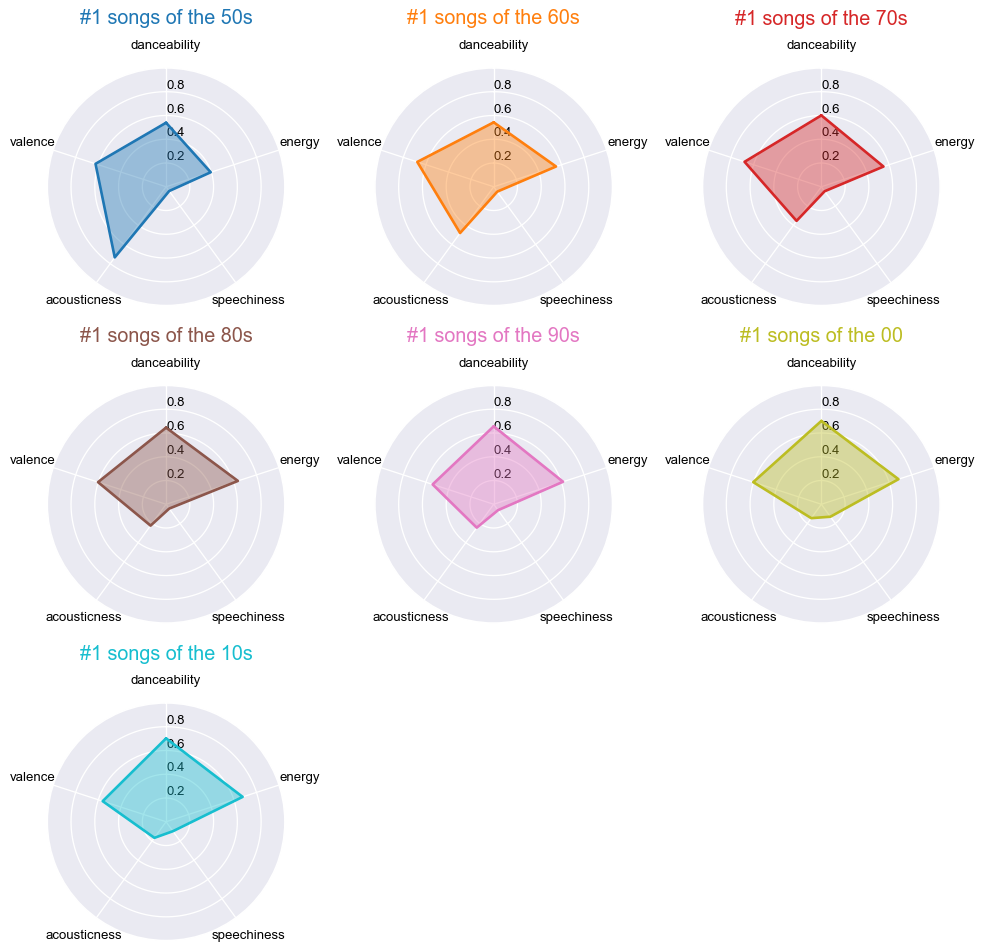

In [176]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

#set data up for plotting onto a radar graph
dance50 = fifties['danceability'].mean()
energy50 = fifties['energy'].mean()
speech50 = fifties['speechiness'].mean()
acoustic50 = fifties['acousticness'].mean()
valence50 = fifties['valence'].mean()

dance60 = sixties['danceability'].mean()
energy60 = sixties['energy'].mean()
speech60 = sixties['speechiness'].mean()
acoustic60 = sixties['acousticness'].mean()
valence60 = sixties['valence'].mean()

dance70 = seventies['danceability'].mean()
energy70 = seventies['energy'].mean()
speech70 = seventies['speechiness'].mean()
acoustic70 = seventies['acousticness'].mean()
valence70 = seventies['valence'].mean()

dance80 = eighties['danceability'].mean()
energy80 = eighties['energy'].mean()
speech80 = eighties['speechiness'].mean()
acoustic80 = eighties['acousticness'].mean()
valence80 = eighties['valence'].mean()

dance90 = nineties['danceability'].mean()
energy90 = nineties['energy'].mean()
speech90 = nineties['speechiness'].mean()
acoustic90 = nineties['acousticness'].mean()
valence90 = nineties['valence'].mean()

dance00 = oughts['danceability'].mean()
energy00 = oughts['energy'].mean()
speech00 = oughts['speechiness'].mean()
acoustic00 = oughts['acousticness'].mean()
valence00 = oughts['valence'].mean()

dance10 = tens['danceability'].mean()
energy10 = tens['energy'].mean()
speech10 = tens['speechiness'].mean()
acoustic10 = tens['acousticness'].mean()
valence10 = tens['valence'].mean()

#create data frame for all of the means for all of the decades to be plotted
plot_df = pd.DataFrame({
'year': ['50s','60s','70s','80s', '90s', '00', '10s'],
'danceability': [dance50, dance60, dance70, dance80, dance90, dance00, dance10],
'energy': [energy50, energy60, energy70, energy80, energy90, energy00, energy10],
'speechiness': [speech50, speech60, speech70, speech80, speech90, speech00, speech10],
'acousticness': [acoustic50, acoustic60, acoustic70, acoustic80,acoustic90, acoustic00, acoustic10],
'valence': [valence50, valence60, valence70, valence80, valence90, valence00, valence10]
})

def make_radar(row, title, color):
     
    #number of attributes for graph
    categories=list(plot_df)[1:]
    N = len(categories)
 
    #size of the angle for each wedge
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider subplot
    ax = plt.subplot(3,3,row+1, polar=True, )
    plt.tight_layout()

    # setting the first axis to the top
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Each attribute gats an axis and a label
    plt.xticks(angles[:-1], categories, color='black', size=10)

    # actual plotting
    values=plot_df.loc[row].drop('year').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    
    # Drawing the y axis labels
    ax.set_rlabel_position(0)
    plt.yticks(np.arange(0, 1, step=0.2), ['', '0.2', '0.4', '0.6', '0.8'], color="black", size=10)
    plt.ylim(0,1)

    # Adding a title
    plt.title(title, size=15, color=color, y=1.15)
    
# creating and initializing the plot with resolution
my_dpi=95
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# Crafting a color palette
my_palette = plt.cm.get_cmap('tab10', len(plot_df.index))
 
# Looping through dataframe to plot
for row in range(0, len(plot_df.index)):
    make_radar( row=row, title='#1 songs of the '+ plot_df['year'][row], color=my_palette(row))
